In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_59038/52946514.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [18]:
class DataAnalyzer:
    def __init__(self):
        file_path = 'cirrhosis.csv'

        self.dataset = pd.read_csv(file_path, header=None)
        self.dataset.columns = self.dataset.iloc[0]

        self.dataset = self.dataset.drop(0)
        self.dataset = self.dataset.drop(self.dataset.columns[0], axis=1)

  
    def fill_nan_vals(self):
        for column in self.dataset.columns:
            if self.dataset[column].dtype == 'object':  # Non-numerical column
                mode_val = self.dataset[column].mode()[0]
                self.dataset[column] = self.dataset[column].fillna(mode_val)
            else:  # Numerical column
                mean_val = self.dataset[column].mean()
                self.dataset[column] = self.dataset[column].fillna(mean_val)

    def drop_nan_vals(self):
        self.dataset = self.dataset.dropna()
        
    def encode_categorical(self):
        label_encoder = LabelEncoder()
        for column in self.dataset.columns:
            if self.dataset[column].dtype == 'object':  # Check if column is categorical
                encoded_values = label_encoder.fit_transform(self.dataset[column])
                self.dataset[column] = encoded_values


    def show_boxplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=3, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.boxplot(y=k, data=self.dataset, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_outlier_percs(self):
        for k, v in self.dataset.items():
            q1 = v.quantile(0.25)
            q3 = v.quantile(0.75)
            irq = q3 - q1
            v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
            perc = np.shape(v_col)[0] * 100.0 / np.shape(self.dataset)[0]
            print("Column %s outliers = %.2f%%" % (k, perc))

    def remove_outliers(self):
        self.dataset = self.dataset[~((self.dataset['quality'] > 7.0) | (self.dataset['quality'] < 4.0))]
        self.dataset = self.dataset[~((self.dataset['density'] > 1.01) | (self.dataset['density'] < 0.98))]
        self.dataset = self.dataset[~((self.dataset['pH'] > 3.59) | (self.dataset['pH'] < 2.78))]
        self.dataset = self.dataset[~((self.dataset['chlorides'] > 0.08))]
        self.dataset = self.dataset[~((self.dataset['volatile acidity'] > 0.5))]
        self.dataset = self.dataset[~((self.dataset['total sulfur dioxide'] > 260.0))]
        self.dataset = self.dataset[~((self.dataset['residual sugar'] > 21.0))]
        self.dataset = self.dataset[~((self.dataset['fixed acidity'] > 9.1))]
        self.dataset = self.dataset[~((self.dataset['citric acid'] > 0.65))]
        return self.dataset

    def get_x_and_Y(self):
        self.X = self.dataset.iloc[:, list(range(11))].values
        self.y = self.dataset.iloc[:, -1].values
        return (self.X, self.y)

    def get_train_test_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.20, random_state = 0)
        return (self.X_train, self.X_test, self.y_train, self.y_test)

    def normalize_df_by_max(self):
        normalized_df = self.dataset.copy()
        for column in self.dataset.columns[:-1]:  # Exclude the last column
            max_abs_value = abs(self.dataset[column]).max()
            normalized_df[column] = self.dataset[column] / max_abs_value

        self.dataset = normalized_df
        return(self.dataset)

    def normalize_df_by_mean(self):
        sc = StandardScaler()
        self.X_train = sc.fit_transform(self.X_train)
        self.X_test = sc.transform(self.X_test)
        return(self.X_train, self.X_test)
    
    def show_histplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=3, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.histplot(v, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_heat_map(self):
        plt.figure(figsize=(20, 10))
        sns.heatmap(self.dataset.corr().abs(),  annot=True)

    def plot_variations(self):
        # Let's scale the columns before plotting them against MEDV
        min_max_scaler = preprocessing.MinMaxScaler()
        # column_sels = ['alcohol', 'density', 'volatile acidity', 'total sulfur dioxide', 'fixed acidity', 'chlorides', 'residual sugar', 'pH']
        column_sels = self.dataset.columns
        x = self.dataset.loc[:,column_sels]
        y = self.dataset['stage']
        x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
        fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for i, k in enumerate(column_sels):
            sns.regplot(y=y, x=x[k], ax=axs[i])
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def perform_knn(self):
        classifier = KNeighborsClassifier(n_neighbors = 40, metric = 'minkowski', p = 2.7)
        classifier.fit(self.X_train, self.y_train)
        y_pred = classifier.predict(self.X_test)
        self.cm = confusion_matrix(self.y_test, y_pred)
        self.ac = accuracy_score(self.y_test,y_pred)
        return self.ac

class Master:
    def __init__(self):
        self.results = {}
        

    def run_raw(self):
        anlyzr = DataAnalyzer()
        anlyzr.fill_nan_vals()
        # anlyzr.drop_nan_vals()
        anlyzr.encode_categorical()
        anlyzr.get_x_and_Y()
        anlyzr.get_train_test_split()
        self.results["raw_run"] = anlyzr.perform_knn()

    def run_after_removing_outliers(self):
        anlyzr = DataAnalyzer()
        anlyzr.remove_outliers()
        anlyzr.get_x_and_Y()
        anlyzr.get_train_test_split()
        self.results["after_removing_outliers_run"] = anlyzr.perform_knn()

    def run_after_max_normalisation(self):
        anlyzr = DataAnalyzer()
        anlyzr.fill_nan_vals()
        # anlyzr.drop_nan_vals()
        anlyzr.encode_categorical()
        anlyzr.normalize_df_by_max()
        anlyzr.get_x_and_Y()
        anlyzr.get_train_test_split()
        self.results["after_max_normalisation_run"] = anlyzr.perform_knn()

    def run_after_mean_normalisation(self):
        anlyzr = DataAnalyzer()
        anlyzr.fill_nan_vals()
        # anlyzr.drop_nan_vals()
        anlyzr.encode_categorical()
        anlyzr.get_x_and_Y()
        anlyzr.get_train_test_split()
        anlyzr.normalize_df_by_mean()
        self.results["after_mean_normalisation_run"] = anlyzr.perform_knn()

In [19]:
def master():
    mastr_func = Master()
    mastr_func.run_raw()
    mastr_func.run_after_removing_outliers()
    mastr_func.run_after_max_normalisation()
    mastr_func.run_after_mean_normalisation()
    return mastr_func.results

master()

KeyError: 'quality'

In [14]:
anlyzr = DataAnalyzer()
anlyzr.fill_nan_vals()
# anlyzr.drop_nan_vals()
anlyzr.encode_categorical()

In [8]:
display(anlyzr.dataset)

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
1,312,2,0,266,0,1,1,1,2,29,68,13,38,111,44,56,55,22,3
2,334,0,0,248,0,0,1,1,0,8,96,139,120,246,15,134,80,6,2
3,1,2,0,332,1,0,0,0,1,11,18,79,62,192,172,103,31,20,3
4,138,2,0,222,0,0,1,1,1,15,54,10,129,209,132,138,51,3,3
5,86,1,1,51,0,0,1,1,0,58,81,84,30,227,14,118,19,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,354,2,0,316,0,0,1,0,0,9,67,31,118,3,140,17,44,9,2
415,17,0,0,60,0,0,1,0,0,6,67,113,118,3,140,17,48,12,3
416,5,0,0,255,0,0,1,0,0,13,67,73,118,3,140,17,25,47,2
417,355,0,0,259,0,0,1,0,0,5,67,105,118,3,140,17,115,4,2


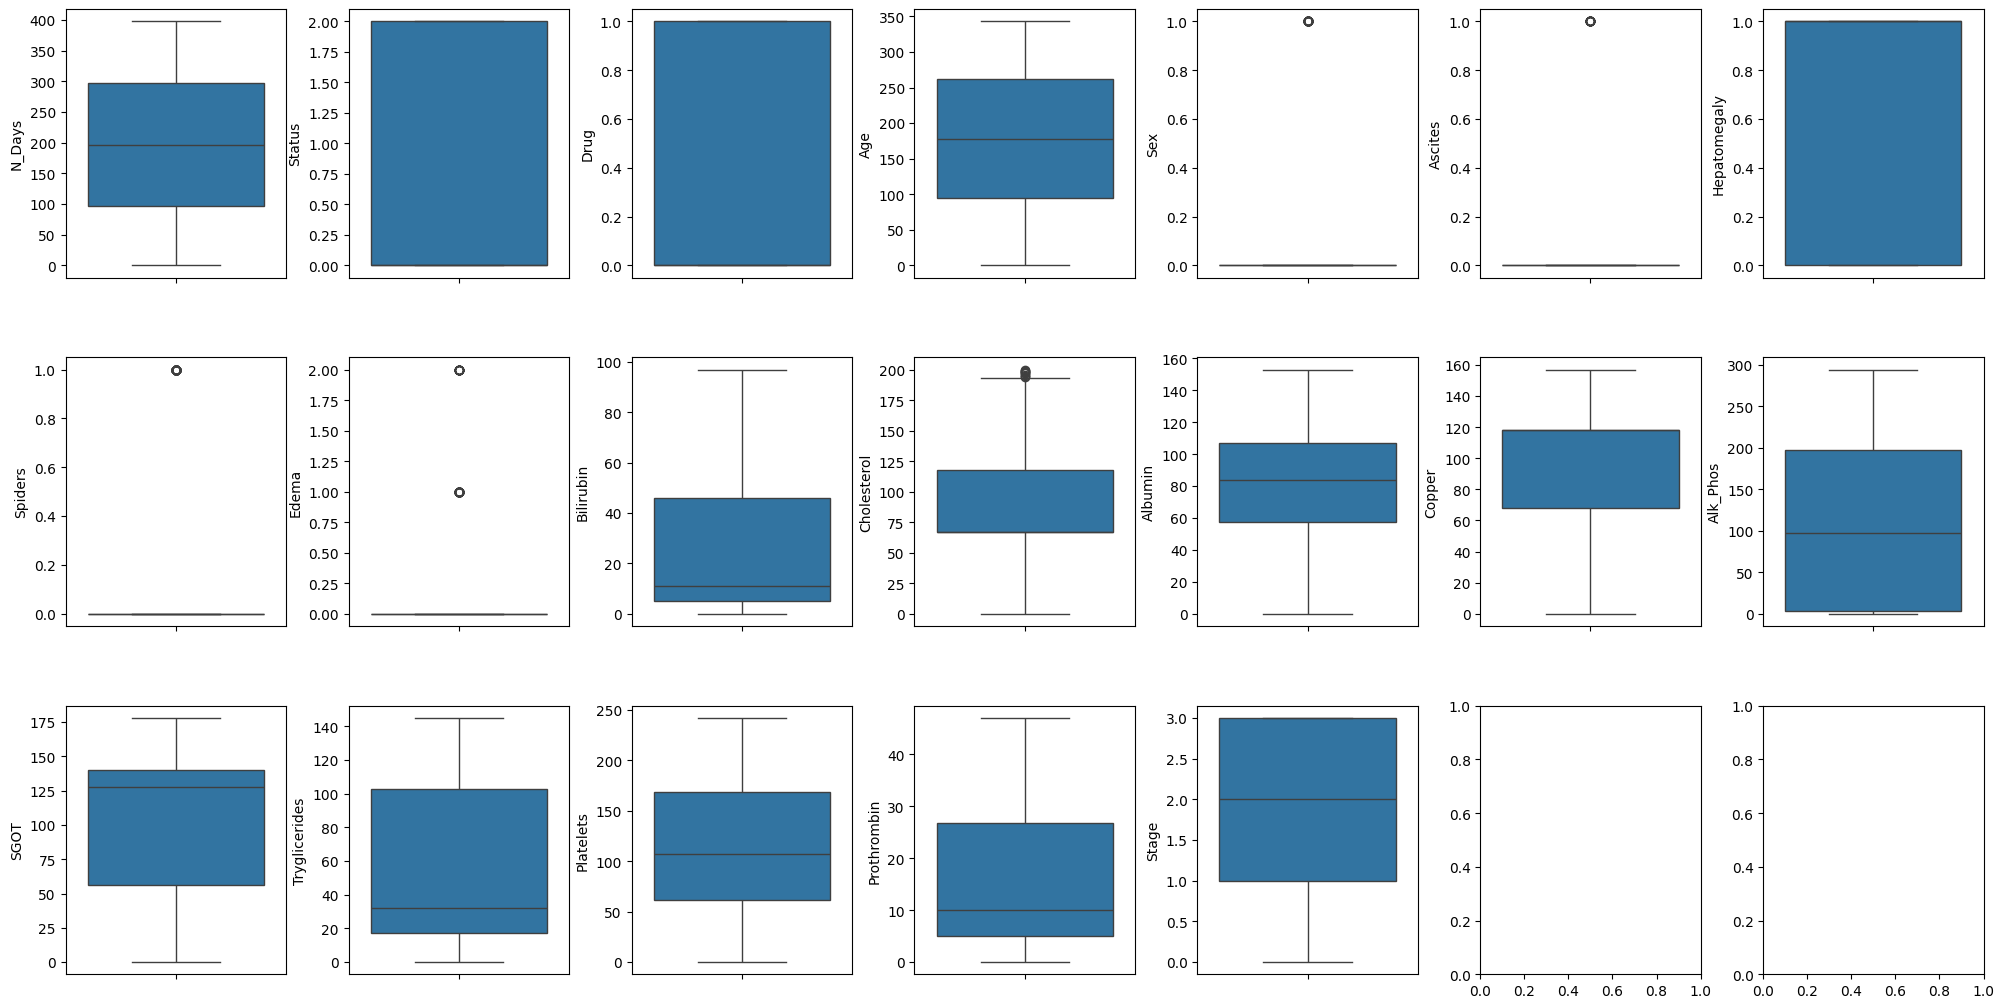

In [9]:
anlyzr.show_boxplots()

In [15]:
anlyzr.get_x_and_Y()
anlyzr.get_train_test_split()
anlyzr.normalize_df_by_mean()

(array([[ 0.76911814, -0.87156329,  1.35296285, ..., -0.4052544 ,
         -0.83775677, -0.56091244],
        [-1.51712854, -0.87156329,  1.35296285, ..., -0.4052544 ,
         -0.76455578, -0.22013071],
        [ 1.50801916,  1.2226967 ,  1.35296285, ..., -0.4052544 ,
          0.77266487,  0.61052475],
        ...,
        [-0.10887013,  1.2226967 , -0.73911859, ..., -0.4052544 ,
          1.21187078,  1.24949049],
        [ 1.16030103, -0.87156329,  1.35296285, ..., -0.4052544 ,
         -0.36195037, -0.43311929],
        [ 0.28231276, -0.87156329, -0.73911859, ..., -0.4052544 ,
          1.02886832, -0.77390102]]),
 array([[ 1.33416010e+00,  1.75566706e-01, -7.39118594e-01,
         -1.06327308e+00, -3.42135728e-01, -2.52377233e-01,
          7.48830864e-01, -4.96254629e-01, -4.05254402e-01,
          1.76087816e+00, -4.11820436e-01],
        [ 1.86690279e-01, -8.71563289e-01, -7.39118594e-01,
          2.09424786e-01, -3.42135728e-01, -2.52377233e-01,
         -1.33541504e+00, -4.

In [16]:
anlyzr.perform_knn()

0.5595238095238095

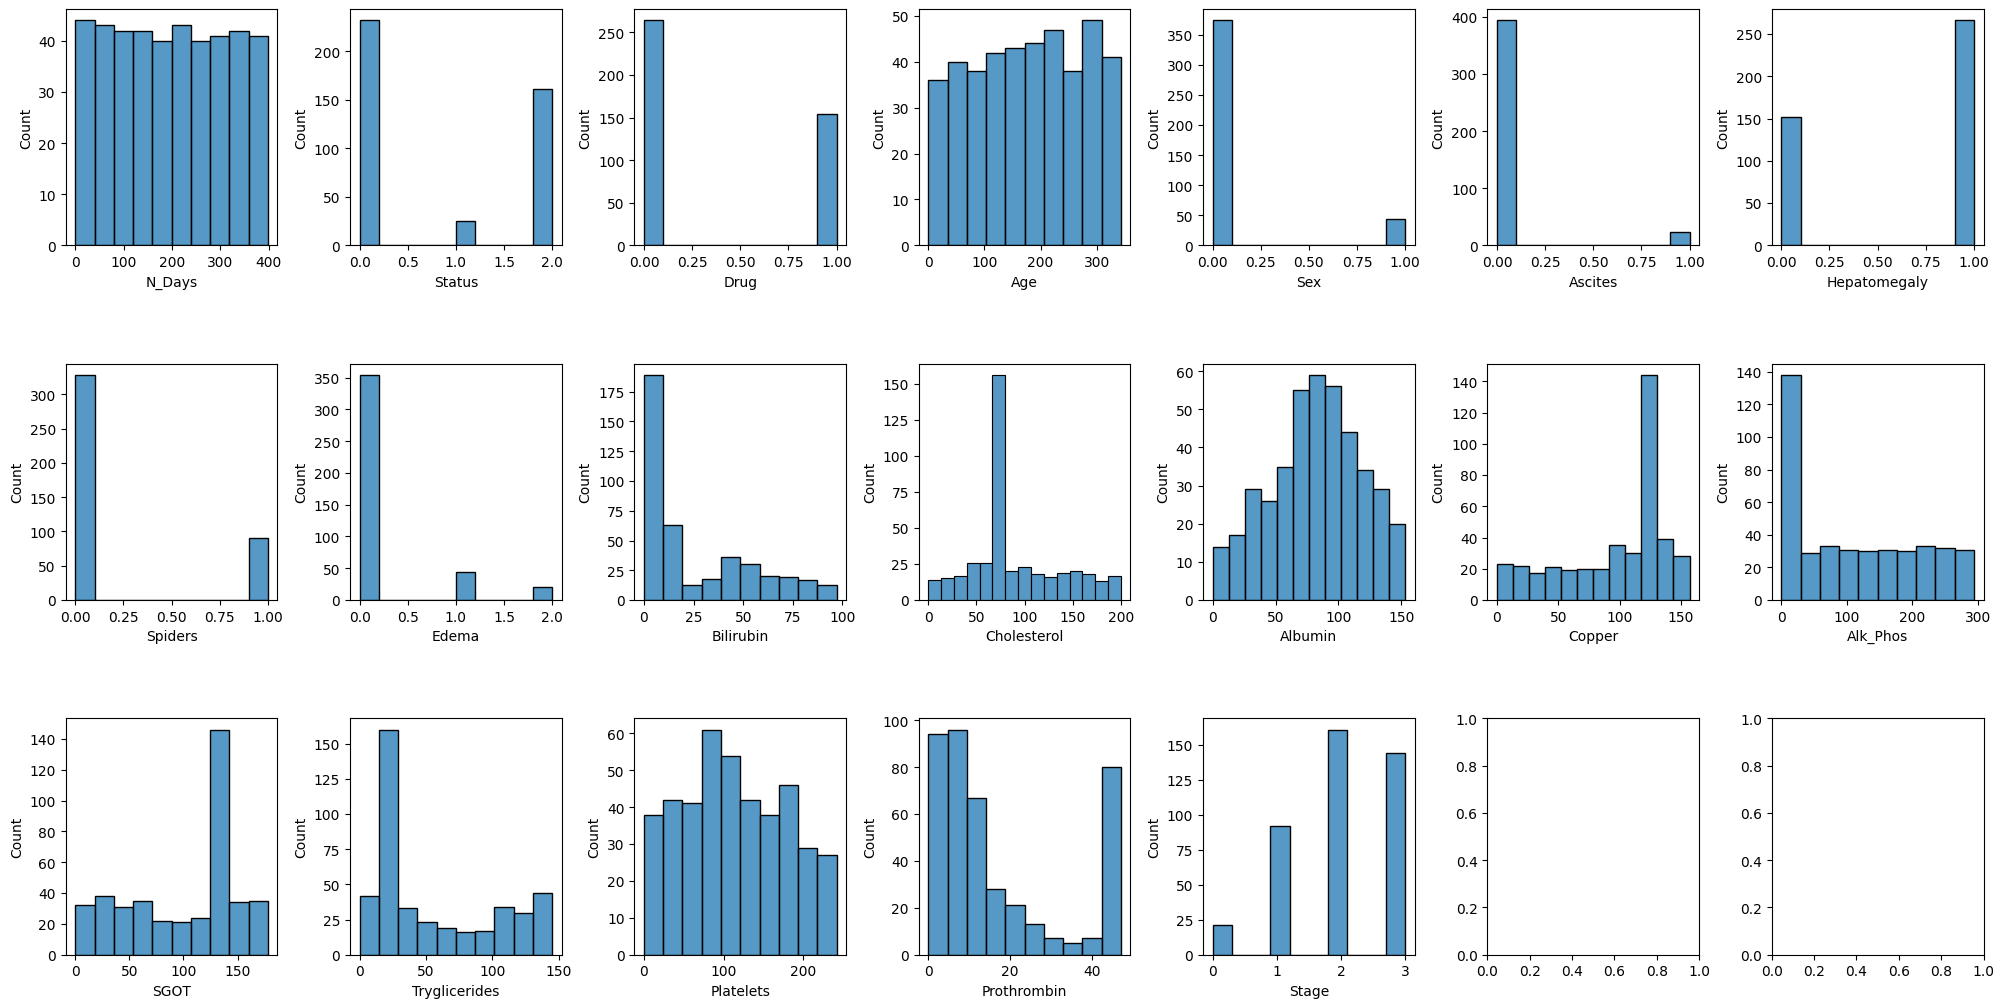

In [17]:
anlyzr.show_histplots()